In [1]:
import os
import sys; sys.path.append("/shome/micheli/HHbbgg_ETH_20181115/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt


Welcome to ROOTaaS 6.05/02


In [2]:
clf_trainings = []
plot_classifier_all = []
fpr_dipho_all,tpr_dipho_all = [],[]
fpr_gJets_all,tpr_gJets_all = [],[]
labels=[]

In [3]:
ntuples = 'deepCSV_01_10_2018'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
#signal = [s for s in files if "SM_" in s ]
#signal = [s for s in files if "SM_plus_nodes" in s ]
signal = [s for s in files if "SM_plus_reweighted_nodes" in s ]
diphotonJets = [s for s in files if "DiPhotonJetsBox_" in s]
diphotonJets_1B = [s for s in files if "DiPhotonJetsBox1B" in s] # will use for limits
diphotonJets_2B = [s for s in files if "DiPhotonJetsBox2B" in s] # will use for limits
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1,'nodesCombined')
utils.IO.add_background(ntuples,diphotonJets,-1,'tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0')
utils.IO.add_background(ntuples,diphotonJets_1B,-1,'tagsDumper/trees/DiPhotonJetsBox1BJet_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0')
utils.IO.add_background(ntuples,diphotonJets_2B,-1,'tagsDumper/trees/DiPhotonJetsBox2BJets_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0')
utils.IO.add_background(ntuples,gJets_lowPt,-2,'tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0')
utils.IO.add_background(ntuples,gJets_highPt,-2,'tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0')



for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018
using background file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-Sherpa.root
using background file n.2: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-Sherpa.root
using background file n.3: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.4: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV

## Folder name where to store output for a specific training

In [4]:
outstr = "15_11_2018_test"
labels.append(outstr)
utils.IO.plotFolder = '/shome/micheli/HHbbgg_ETH_20181115/HHbbgg_ETH/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

In [5]:
from ROOT import TLorentzVector

#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
########################new code branches############################
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
branch_names = 'leadingJet_DeepCSV,subleadingJet_DeepCSV,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
b_reg_branches = 'noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826)'.split(",")
branch_cuts = 'leadingJet_pt,subleadingJet_pt,leadingJet_bRegNNCorr,subleadingJet_bRegNNCorr,noexpand:(leadingJet_pt/leadingJet_bRegNNCorr),noexpand:(subleadingJet_pt/subleadingJet_bRegNNCorr)'.split(',')
#cuts = 'leadingJet_pt>20 & subleadingJet_pt> 20 & (leadingJet_pt/leadingJet_bRegNNCorr>20) & (subleadingJet_pt/subleadingJet_bRegNNCorr>20) '
cuts = 'leadingJet_pt>0'
######################

#event_branches = ['event','sigmaMOverM','noexpand:(dijetSigmaMOverM*1.4826)']
event_branches = ['event','weight','leadingJet_hflav','leadingJet_pflav','subleadingJet_hflav','subleadingJet_pflav']

branch_names = branch_names+b_reg_branches
resolution_weighting = 'ggbb' # None, gg or ggbb


branch_names = [c.strip() for c in branch_names]
print branch_names

event_bkg,event_sig = None,None

preprocessing.set_signals_and_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)

if 'gg' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='sigmaMOverMDecorr')
if 'bb' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='(sigmaMJets*1.4826)')

for i in range(utils.IO.nBkg):
    if 'DiPhotonJetsBox_MGG' in utils.IO.bkgTreeName[i] : preprocessing.cleanOverlapDiphotons(utils.IO.bkgTreeName[i],utils.IO.background_df[i])        
        
X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.set_variables(branch_names,use_event_num=True)

info_file = open(utils.IO.plotFolder+"info_%s.txt"%outstr,"w") 
info_file.write("\n".join(branch_names))
info_file.write("Resolution weighting : %s\n"%resolution_weighting)
info_file.write("Cuts : %s\n"%cuts)
info_file.close()

weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

#######correct weight
#weights_bkg=preprocessing.scale_process_weight(weights_bkg,y_bkg,-3.,0.0049)
#try to increase weight of ggH
#weights_bkg=preprocessing.scale_process_weight(weights_bkg,y_bkg,-3.,0.049)
#weights_bkg=preprocessing.scale_process_weight(weights_bkg,y_bkg,-4.,0.00044)

X_bkg,y_bkg,weights_bkg,event_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg,event_num = np.asarray(event_bkg))
X_sig,y_sig,weights_sig,event_sig = preprocessing.randomize(X_sig,y_sig,weights_sig,event_num = np.asarray(event_sig))


#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig,event_num_bkg = event_bkg, event_num_sig = event_sig)


#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig,event_bkg.reshape(-1,))

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig,event_bkg.reshape(-1,))

w_total_train = preprocessing.get_total_training_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()



#y_total_train = preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
#X_total_train = preprocessing.get_total_training_sample(X_sig,X_bkg)

#y_total_test = preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
#X_total_test = preprocessing.get_total_test_sample(X_sig,X_bkg)

##w_total_test = preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()


['leadingJet_DeepCSV', 'subleadingJet_DeepCSV', 'absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'PhoJetMinDr', 'noexpand:(leadingJet_bRegNNResolution*1.4826)', 'noexpand:(subleadingJet_bRegNNResolution*1.4826)', 'noexpand:(sigmaMJets*1.4826)']
using tree:nodesCombined
using tree:tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/DiPhotonJetsBox1BJet_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/DiPhotonJetsBox2BJets_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
2398.3791

In [26]:
print y_total_test.shape
print y_total_train.shape
print y_sig.shape, y_bkg.shape

(584404,)
(807756,)
(1017535,) (374625, 1)


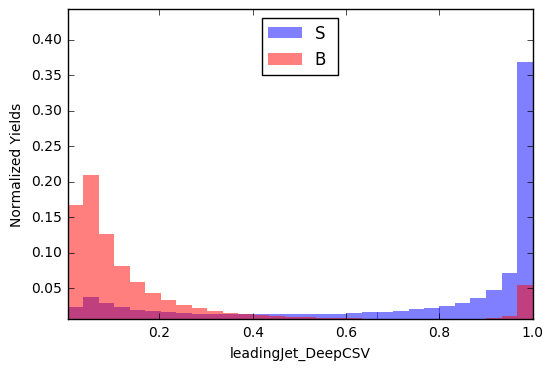

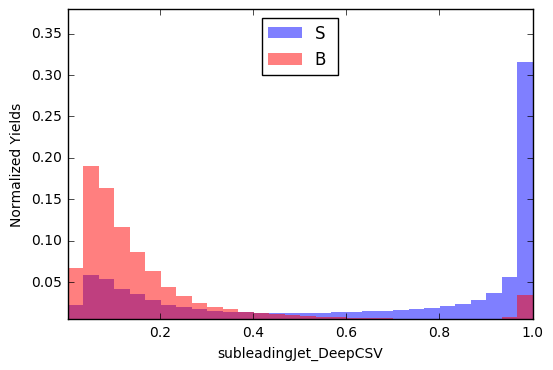

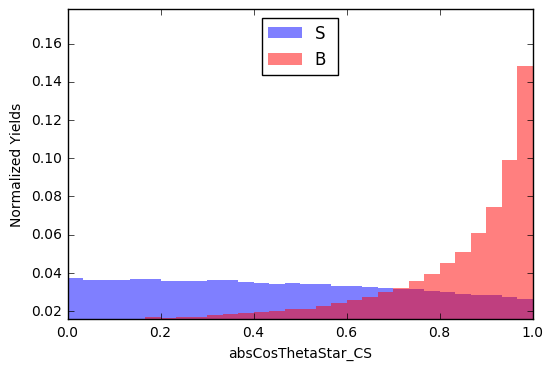

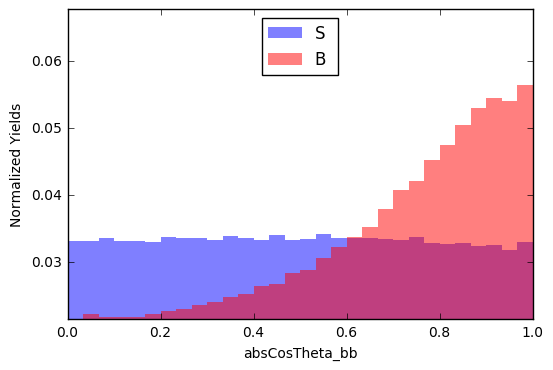

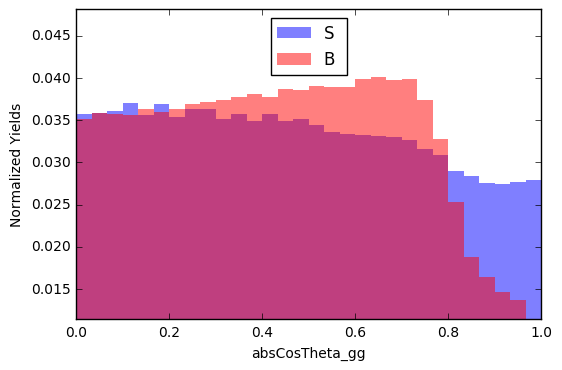

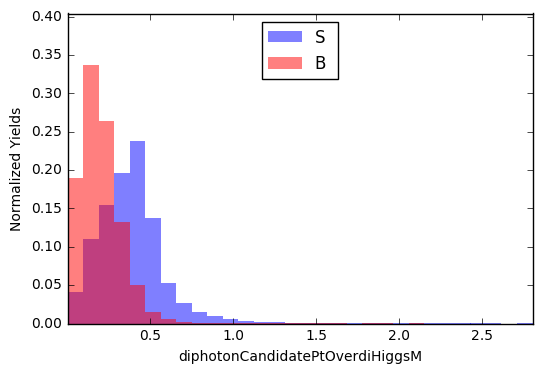

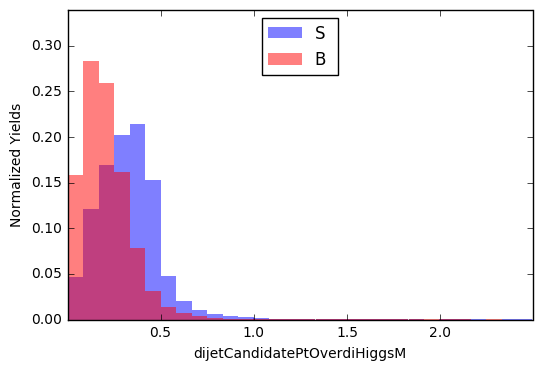

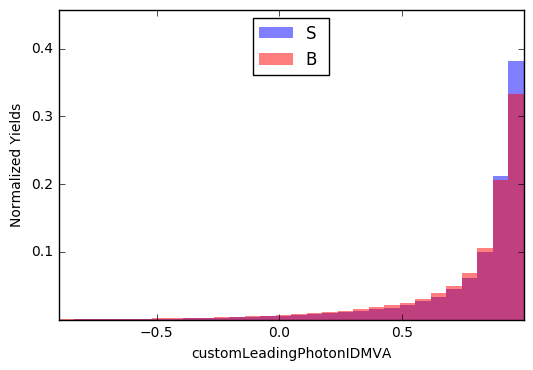

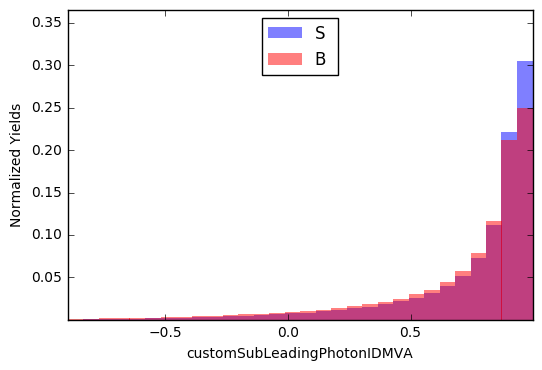

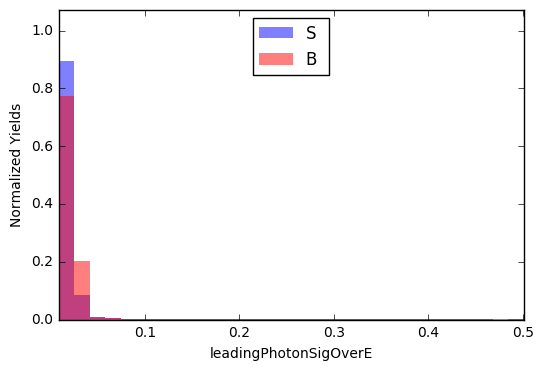

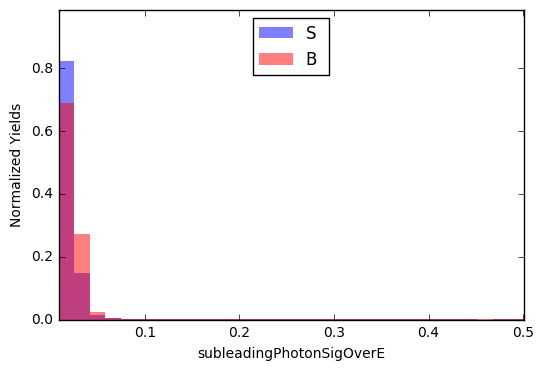

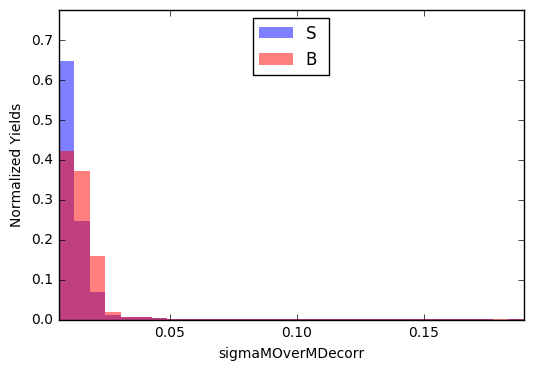

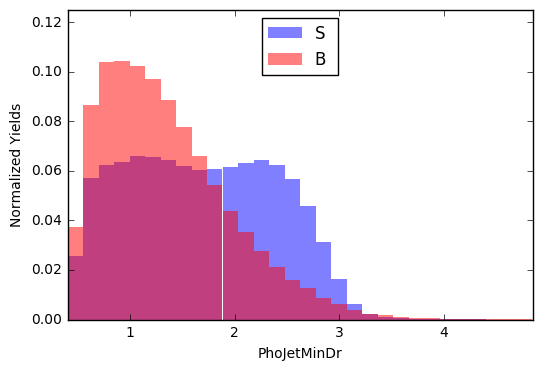

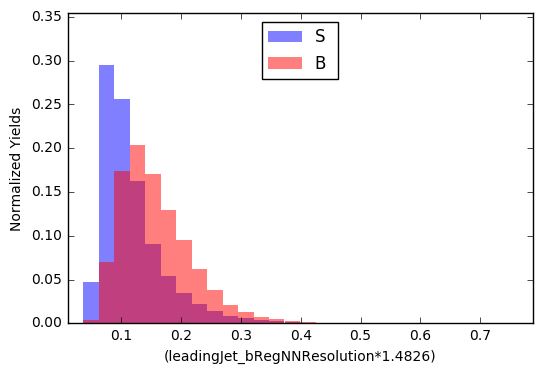

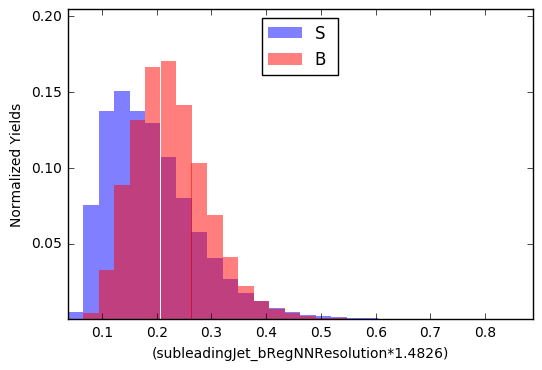

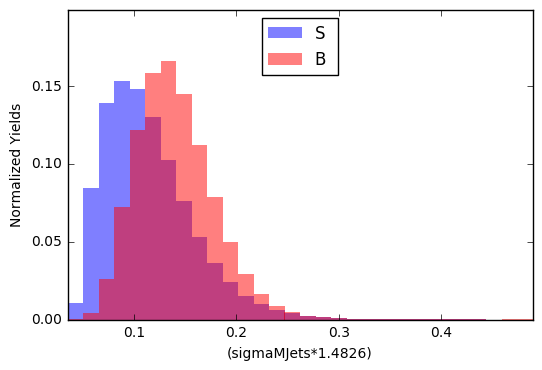

In [27]:
plotting.plot_input_variables(X_sig,X_bkg,branch_names+branch_cuts,None,30,'deep_CSV')
#utils.IO.signal_df[0]['(subleadingJet_pt/subleadingJet_bRegNNCorr)'].plot.hist(bins=100,range=[0,50])
#plt.show()

In [38]:
########final optimization with all fixed#######
from sklearn.externals import joblib
import xgboost as xgb
#optimized parameters

clf = xgb.XGBClassifier(base_score=0.5,  colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=10, min_child_weight=1e-05, missing=None,
       n_estimators=1000, nthread=20, objective='binary:logistic',
       reg_alpha=0.0, reg_lambda=0.1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

#the smallest classifier from optimized grid
grid={'reg_alpha': 0.0, 'learning_rate': 0.2, 'min_child_weight': 0.0001, 'n_estimators': 1000, 'reg_lambda': 0.05, 'max_depth': 3, 'gamma': 0}
clf.set_params(**grid)

clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)
joblib.dump(clf, os.path.expanduser('/shome/micheli/HHbbgg_ETH_20181115/HHbbgg_ETH/Training/training_std_nadya_%s.pkl'%outstr), compress=9)
clf_trainings.append(clf)

(807756, 16)


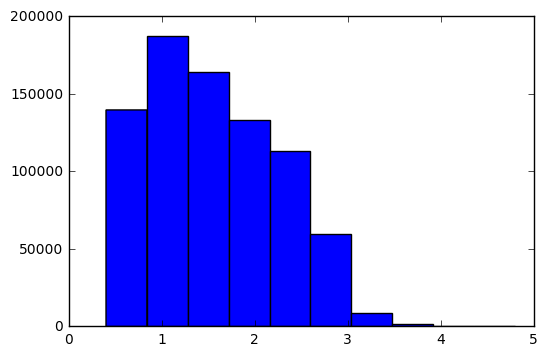

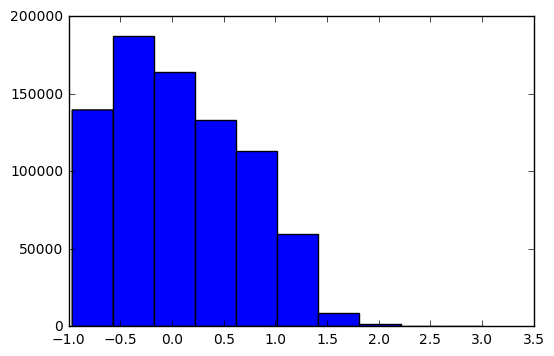

In [39]:
#####################FRANCESCO#############################
###############normalize variables#######################
print X_total_train.shape
plt.hist(X_total_train[:,12])
plt.show()
from sklearn.preprocessing import RobustScaler
#transformer = RobustScaler().fit(X_total_train_2[:,12].reshape(-1,1))
transformer = RobustScaler().fit(X_total_train)
transformer
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)
X_total_train_2 = transformer.transform(X_total_train)
plt.hist(array[:,12])
plt.show()

In [40]:
#####################FRANCESCO#############################
###############train classifier with normalized variables#######################
#optimized parameters

clf_norm = xgb.XGBClassifier(base_score=0.5,  colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=10, min_child_weight=1e-05, missing=None,
       n_estimators=1000, nthread=20, objective='binary:logistic',
       reg_alpha=0.0, reg_lambda=0.1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

#the smallest classifier from optimized grid
grid={'reg_alpha': 0.0, 'learning_rate': 0.2, 'min_child_weight': 0.0001, 'n_estimators': 1000, 'reg_lambda': 0.05, 'max_depth': 3, 'gamma': 0}
clf_norm.set_params(**grid)

clf_norm.fit(X_total_train_2,y_total_train, sample_weight=w_total_train)
joblib.dump(clf, os.path.expanduser('/shome/micheli/HHbbgg_ETH_20181115/HHbbgg_ETH/Training/training_norm_%s.pkl'%outstr), compress=9)
clf_trainings.append(clf_norm)

In [41]:
gg_clf = joblib.load(os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_14_11_2018_2016_gg.pkl'))
clf_trainings = [gg_clf] + clf_trainings

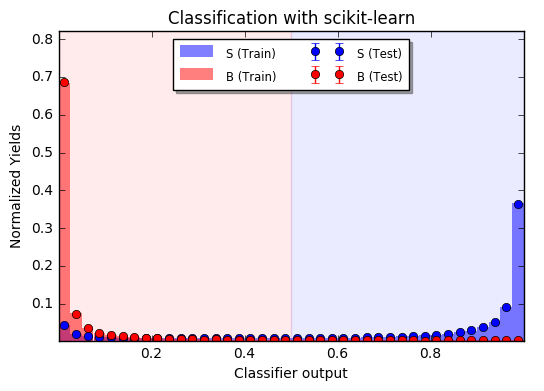

In [41]:
plt.clf()
plot_classifier = plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString=outstr)
plt.show()

plot_classifier_all.append(plot_classifier)

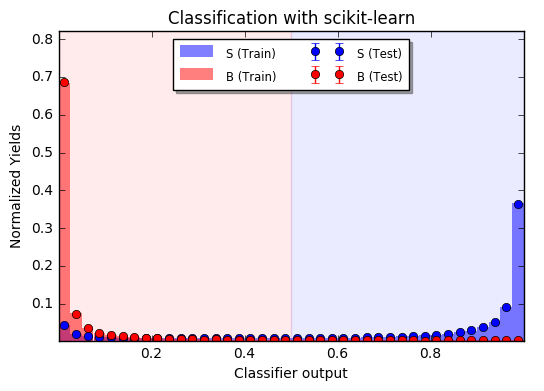

In [45]:
#####################FRANCESCO#############################
###############normalize X_test and plot classifier#######################

from sklearn.preprocessing import RobustScaler
#transformer = RobustScaler().fit(X_total_train_2[:,12].reshape(-1,1))
transformer = RobustScaler().fit(X_total_train)
transformer
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)
X_total_test_2 = transformer.transform(X_total_test)
plot_classifier = plotting.plot_classifier_output(clf_norm,X_total_train_2,X_total_test_2,y_total_train,y_total_test,outString=outstr)
plt.show()

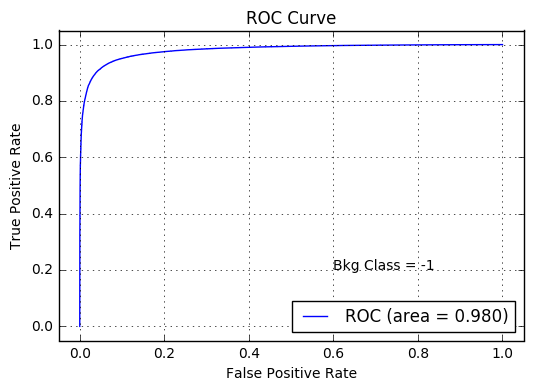

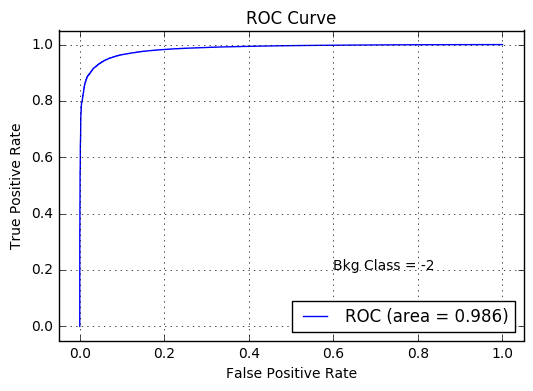

In [49]:
fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
plt.show()
fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)
plt.show()

fpr_dipho_all.append(fpr_dipho)
tpr_dipho_all.append(tpr_dipho)
fpr_gJets_all.append(fpr_gJets)
tpr_gJets_all.append(tpr_gJets)

In [44]:
for clf in clf_trainings:
    fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
    fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)

    fpr_dipho_all.append(fpr_dipho)
    tpr_dipho_all.append(tpr_dipho)
    fpr_gJets_all.append(fpr_gJets)
    tpr_gJets_all.append(tpr_gJets)

In [45]:
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr

In [ ]:
print labels
labels[0][labels[0].find('les')+4:]

In [ ]:
labels_legend = [labels[i][labels[i].find('bles')+4:] for i in range(0,len(labels))]
labels_legend = [labels[i] for i in range(0,len(labels))]

In [46]:
labels_legend = ['gg,g+jets','gg,gg+b-jets,g+jets']
labels = labels_legend

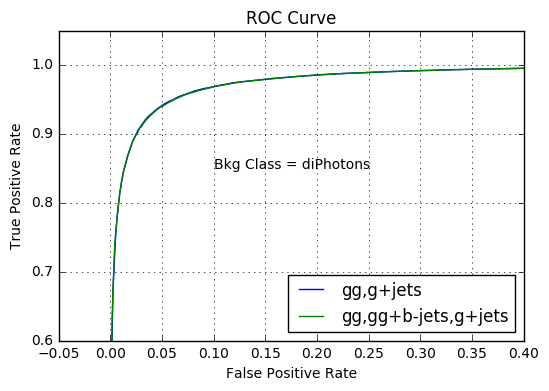

In [49]:
plt.clf()
for i in range(0,len(labels)):
    plt.plot(fpr_dipho_all[i], tpr_dipho_all[i], lw=1, label=labels_legend[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = diPhotons')
plt.grid()
outString = "comparison_diphotons_vs_benriched_diphotonsRoc"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

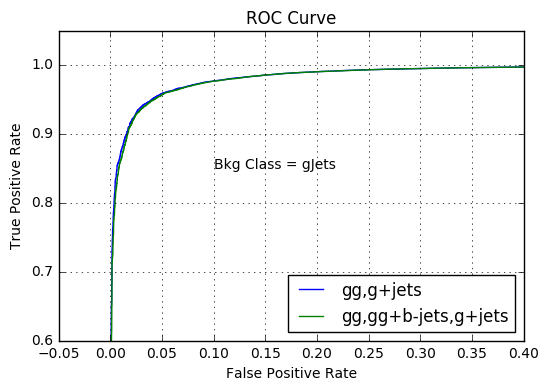

In [50]:
for i in range(0,len(labels)):
    plt.plot(fpr_gJets_all[i], tpr_gJets_all[i], lw=1, label=labels_legend[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = gJets')
plt.grid()
outString = "comparison_diphotons_vs_benriched_gJetsRoc"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

In [5]:
X_bkg[np.where(event_bkg%2==0),:][0]

NameError: name 'X_bkg' is not defined

(807756, 16)


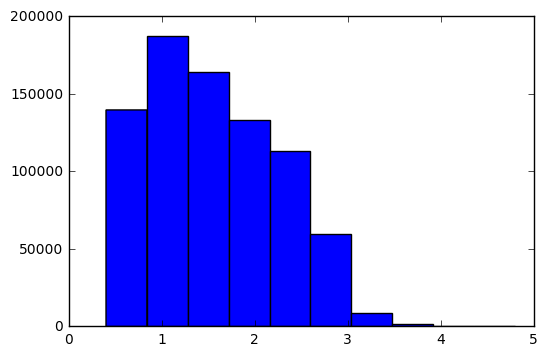

[ 1.72019  1.36361  1.44589 ...,  0.8238   1.35399  1.80524]


In [23]:
print X_total_train.shape
plt.hist(X_total_train[:,12])
plt.show()
print X_total_train[:,12]

In [24]:
from copy import deepcopy
X_total_train_2= deepcopy(X_total_train)
from sklearn.preprocessing import RobustScaler
#transformer = RobustScaler().fit(X_total_train_2[:,12].reshape(-1,1))
transformer = RobustScaler().fit(X_total_train_2)
transformer
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)
array = transformer.transform(X_total_train_2)

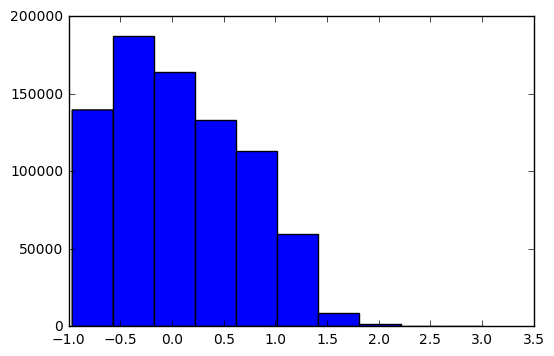

In [25]:
plt.hist(array[:,12])
plt.show()